# Import necessary packages

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from skimage.io import imshow
from skimage.transform import resize
# from skimage.morphology import label
# from skimage.feature import structure_tensor
from sklearn.model_selection import train_test_split
# from PIL import Image, ImageDraw
import cv2

import tensorflow as tf

from keras import backend as K
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [2]:
# Problem:
# Robustness of the model and transferability, because of different acquisition and muscles and setting on the ultrasound devices
# Test if area estimation makes sense when measured if completely automated 


In [51]:
# Test whether GPU is present and recognized

physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], False)

Num GPUs Available:  1


## Define custom functions

In [4]:
# Convolution block
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size), \
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

# Create u-net model
def get_unet(input_img, n_filters = 64, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    
    # Contracting Path
    # c is output tensor of conv layers
    # p ist output tensor of max pool layers
    # u is output tensor of up-sampling (transposed) layers
    # Batchnorm standardizes/normalizes the output of each layer where applied in order to avoid huge weights using 
    # z-scores 
    
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

# Compute Intersection over union (IoU), a measure of labelling accuracy
# NOTE: This is sometimes also called Jaccard score
def IoU(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection
    iou = (intersection + smooth) / ( union + smooth)
    return iou

# IMAGE AUGMENTATION

## Use only when training new models and not enough data 

In [5]:
'''
# Creating image augmentation function
gen = ImageDataGenerator(rotation_range=10, 
                        width_shift_range=0.1, 
                        height_shift_range=0.1,
                        zoom_range=0.1,
                        horizontal_flip=True)

ids = os.listdir("apo_image_csa_VL/insert_images")
seed = 1
batch_size = 1
num_aug_images = 2 # Number of images added from augmented dataset. 


for i in range(int(len(ids) + 1)):
    
    # Choose image & mask that should be augmented -> watch out for folder sturcture
    chosen_image = ids[i] 
    image_path = "apo_image_csa_VL/insert_images/" + chosen_image 
    mask_path = "apo_masks_csa_VL/insert_masks/" + chosen_image
    image = np.expand_dims(plt.imread(image_path),0) # Read and expand image dimensions
    mask = np.expand_dims(np.expand_dims(plt.imread(mask_path),0),-1)

    # Augment images and save to folder 
    aug_image = gen.flow(image, batch_size=batch_size, seed=seed, save_to_dir="apo_image_csa_VL/insert_images", save_prefix="vl"+str(i), save_format="tif")
    aug_mask = gen.flow(mask, batch_size=batch_size, seed=seed, save_to_dir="apo_masks_csa_VL/insert_masks", save_prefix="vl"+str(i), save_format="tif")
    seed = seed + 1 
     
    # Add images to folder
    for i in range(num_aug_images + 1):
        next(aug_image)[0].astype(np.uint8)
        next(aug_mask)[0].astype(np.uint8)
        
   
'''

'\n# Creating image augmentation function\ngen = ImageDataGenerator(rotation_range=10, \n                        width_shift_range=0.1, \n                        height_shift_range=0.1,\n                        zoom_range=0.1,\n                        horizontal_flip=True)\n\nids = os.listdir("apo_image_csa_VL/insert_images")\nseed = 1\nbatch_size = 1\nnum_aug_images = 2 # Number of images added from augmented dataset. \n\n\nfor i in range(int(len(ids) + 1)):\n    \n    # Choose image & mask that should be augmented -> watch out for folder sturcture\n    chosen_image = ids[i] \n    image_path = "apo_image_csa_VL/insert_images/" + chosen_image \n    mask_path = "apo_masks_csa_VL/insert_masks/" + chosen_image\n    image = np.expand_dims(plt.imread(image_path),0) # Read and expand image dimensions\n    mask = np.expand_dims(np.expand_dims(plt.imread(mask_path),0),-1)\n\n    # Augment images and save to folder \n    aug_image = gen.flow(image, batch_size=batch_size, seed=seed, save_to_dir=

# APONEUROSIS TRAINING

# Set image scaling parameters, determine no. of images for training

In [46]:
# Images will be re-scaled
im_width = 256
im_height = 256
border = 5

# list of all images in the path
ids = os.listdir("apo_image_csa_VL/insert_images")
print("Total no. of aponeurosis images = ", len(ids))
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

Total no. of aponeurosis images =  1344


# Load images and corresponding labels (masks)

In [55]:
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img("apo_image_csa_VL/insert_images/"+id_, color_mode='grayscale')
    x_img = img_to_array(img)
    x_img = resize(x_img, (256, 256, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask = img_to_array(load_img("apo_masks_csa_VL/insert_masks/"+id_, color_mode='grayscale'))
    mask = resize(mask, (256, 256, 1), mode = 'constant', preserve_range = True)
    # Normalise and store images
    X[n] = x_img/255.0
    y[n] = mask/255.0

<ipython-input-55-7af7aaea1060>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):


  0%|          | 0/1344 [00:00<?, ?it/s]

# Set up aponeurosis training

In [56]:
# Split data into training and validation
#X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1) # i.e. 90% training / 10% test split

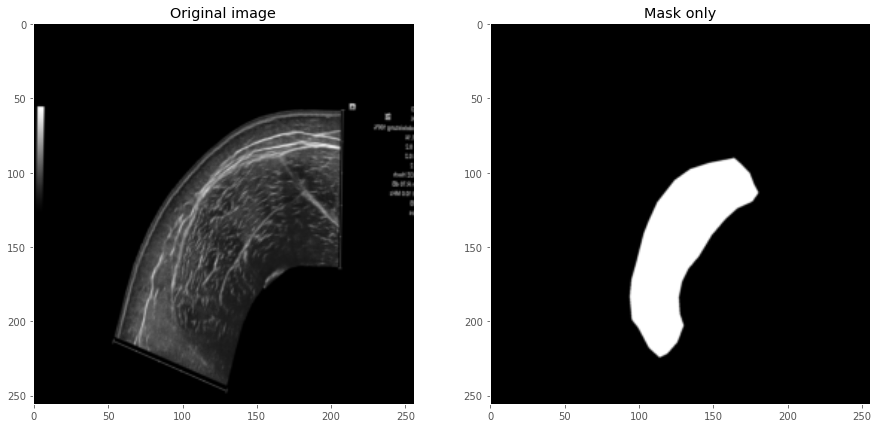

In [57]:
# Visualize a random image along with the mask (not necessary, just for checking)
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # Check whether there's at least 1 aponeurosis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 12))
ax1.imshow(X_train[ix, ..., 0], cmap = 'gray', interpolation = 'bilinear')
if has_mask: # if at least 1 aponeurosis is present
    #draw the aponeuroses on the original image
    #ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 0, levels = [0.5])
    ax1.set_title('Original image')
    ax1.grid(False)
    ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
    ax2.set_title('Mask only')
    ax2.grid(False)

In [ ]:
# Compile the aponeurosis model
input_img = Input((im_height, im_width, 1), name='img')
model_apo = get_unet(input_img, n_filters=64, dropout=0.25, batchnorm=True) # If n_filters = 64 & Size 512x512 OOM error...
model_apo.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy", IoU])

In [ ]:
# Show a summary of the model structure
model_apo.summary()

In [ ]:
# Set some training parameters
# Saves the model, lowers learning rate if val los plateaus and performs early stopping. 
callbacks = [
    EarlyStopping(patience=8, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-acsa-VL-256+64.h5', verbose=1, save_best_only=True, save_weights_only=False), # Give the model a name (the .h5 part)
    CSVLogger('acsa_weights_VL-256+64.csv', separator=',', append=False)
]

# Train the aponeurosis model (keep batch size small!)

In [45]:
results = model_apo.fit(X_train, y_train, batch_size=1, epochs=60, callbacks=callbacks, validation_data=(X_valid, y_valid))

Epoch 1/60


ResourceExhaustedError: in user code:

    C:\Program Files\Anaconda3\envs\Deep_ACSAuto\lib\site-packages\tensorflow\python\keras\engine\training.py:805 train_function  *
        return step_function(self, iterator)
    C:\Program Files\Anaconda3\envs\Deep_ACSAuto\lib\site-packages\tensorflow\python\keras\engine\training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Program Files\Anaconda3\envs\Deep_ACSAuto\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Program Files\Anaconda3\envs\Deep_ACSAuto\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Program Files\Anaconda3\envs\Deep_ACSAuto\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Program Files\Anaconda3\envs\Deep_ACSAuto\lib\site-packages\tensorflow\python\keras\engine\training.py:788 run_step  **
        outputs = model.train_step(data)
    C:\Program Files\Anaconda3\envs\Deep_ACSAuto\lib\site-packages\tensorflow\python\keras\engine\training.py:757 train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    C:\Program Files\Anaconda3\envs\Deep_ACSAuto\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:498 minimize
        return self.apply_gradients(grads_and_vars, name=name)
    C:\Program Files\Anaconda3\envs\Deep_ACSAuto\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:604 apply_gradients
        self._create_all_weights(var_list)
    C:\Program Files\Anaconda3\envs\Deep_ACSAuto\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:783 _create_all_weights
        self._create_slots(var_list)
    C:\Program Files\Anaconda3\envs\Deep_ACSAuto\lib\site-packages\tensorflow\python\keras\optimizer_v2\adam.py:127 _create_slots
        self.add_slot(var, 'm')
    C:\Program Files\Anaconda3\envs\Deep_ACSAuto\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:847 add_slot
        weight = tf_variables.Variable(
    C:\Program Files\Anaconda3\envs\Deep_ACSAuto\lib\site-packages\tensorflow\python\ops\variables.py:262 __call__
        return cls._variable_v2_call(*args, **kwargs)
    C:\Program Files\Anaconda3\envs\Deep_ACSAuto\lib\site-packages\tensorflow\python\ops\variables.py:244 _variable_v2_call
        return previous_getter(
    C:\Program Files\Anaconda3\envs\Deep_ACSAuto\lib\site-packages\tensorflow\python\ops\variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    C:\Program Files\Anaconda3\envs\Deep_ACSAuto\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3332 creator
        return next_creator(**kwargs)
    C:\Program Files\Anaconda3\envs\Deep_ACSAuto\lib\site-packages\tensorflow\python\ops\variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    C:\Program Files\Anaconda3\envs\Deep_ACSAuto\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3332 creator
        return next_creator(**kwargs)
    C:\Program Files\Anaconda3\envs\Deep_ACSAuto\lib\site-packages\tensorflow\python\ops\variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    C:\Program Files\Anaconda3\envs\Deep_ACSAuto\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3332 creator
        return next_creator(**kwargs)
    C:\Program Files\Anaconda3\envs\Deep_ACSAuto\lib\site-packages\tensorflow\python\ops\variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    C:\Program Files\Anaconda3\envs\Deep_ACSAuto\lib\site-packages\tensorflow\python\eager\def_function.py:712 variable_capturing_scope
        v = UnliftedInitializerVariable(
    C:\Program Files\Anaconda3\envs\Deep_ACSAuto\lib\site-packages\tensorflow\python\ops\variables.py:264 __call__
        return super(VariableMetaclass, cls).__call__(*args, **kwargs)
    C:\Program Files\Anaconda3\envs\Deep_ACSAuto\lib\site-packages\tensorflow\python\eager\def_function.py:227 __init__
        initial_value = initial_value()
    C:\Program Files\Anaconda3\envs\Deep_ACSAuto\lib\site-packages\tensorflow\python\keras\initializers\initializers_v2.py:139 __call__
        return super(Zeros, self).__call__(shape, dtype=_get_dtype(dtype), **kwargs)
    C:\Program Files\Anaconda3\envs\Deep_ACSAuto\lib\site-packages\tensorflow\python\ops\init_ops_v2.py:154 __call__
        return array_ops.zeros(shape, dtype)
    C:\Program Files\Anaconda3\envs\Deep_ACSAuto\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Program Files\Anaconda3\envs\Deep_ACSAuto\lib\site-packages\tensorflow\python\ops\array_ops.py:2819 wrapped
        tensor = fun(*args, **kwargs)
    C:\Program Files\Anaconda3\envs\Deep_ACSAuto\lib\site-packages\tensorflow\python\ops\array_ops.py:2880 zeros
        output = fill(shape, constant(zero, dtype=dtype), name=name)
    C:\Program Files\Anaconda3\envs\Deep_ACSAuto\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Program Files\Anaconda3\envs\Deep_ACSAuto\lib\site-packages\tensorflow\python\ops\array_ops.py:239 fill
        result = gen_array_ops.fill(dims, value, name=name)
    C:\Program Files\Anaconda3\envs\Deep_ACSAuto\lib\site-packages\tensorflow\python\ops\gen_array_ops.py:3347 fill
        _ops.raise_from_not_ok_status(e, name)
    C:\Program Files\Anaconda3\envs\Deep_ACSAuto\lib\site-packages\tensorflow\python\framework\ops.py:6862 raise_from_not_ok_status
        six.raise_from(core._status_to_exception(e.code, message), None)
    <string>:3 raise_from
        

    ResourceExhaustedError: OOM when allocating tensor with shape[3,3,256,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Fill]


## Visualise the results of training

In [ ]:
# Variables stored in results.history: val_loss, val_acc, val_IoU, loss, acc, IoU, lr
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].plot(results.history["loss"], label="Training loss")
ax[0].plot(results.history["val_loss"], label="Validation loss")
ax[0].set_title('Learning curve')
ax[0].plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("log_loss")
ax[0].legend();

ax[1].plot(results.history["val_IoU"], label="Training IoU")
ax[1].plot(results.history["IoU"], label="Validation IoU")
ax[1].set_title("IoU curve")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("IoU score")
ax[1].legend();

plt.savefig("512Pi+32Fil-Learning+IOC-curve-VL.tif")

In [33]:
results.history # Show the loss values (these are saved to a .csv file using 'CSVLogger' callback defined above)

{'loss': [0.05820266902446747,
  0.039351705461740494,
  0.03246718645095825,
  0.027835845947265625,
  0.025049325078725815,
  0.023126747459173203,
  0.020500537008047104,
  0.019183510914444923,
  0.01846224255859852,
  0.017653178423643112,
  0.01640111580491066,
  0.015567431226372719,
  0.015101796016097069,
  0.014520961791276932,
  0.01385892741382122,
  0.013469318859279156,
  0.013027121312916279,
  0.012240136042237282,
  0.012278089299798012,
  0.011627236381173134,
  0.011557690799236298,
  0.011438586749136448,
  0.011155735701322556,
  0.010485979728400707,
  0.010594352148473263,
  0.010579666122794151,
  0.009986715391278267,
  0.00999572966247797,
  0.009591208770871162,
  0.009963910095393658],
 'accuracy': [0.9707828164100647,
  0.9774417281150818,
  0.9799717664718628,
  0.9814457893371582,
  0.9824289679527283,
  0.9830188155174255,
  0.9839807152748108,
  0.9842885732650757,
  0.9845705032348633,
  0.9848542213439941,
  0.9852524995803833,
  0.9854768514633179,
 

In [35]:
# Predict on training and validations sets
#model_apo = load_model("model-acsa.h5", custom_objects={'IoU': IoU})
#model_apo_VL = load_model("model-acsa-512+32-RF.h5", custom_objects={"IoU": IoU})
preds_train = model_apo.predict(X_train, verbose=1, batch_size=1)
preds_val = model_apo.predict(X_valid, verbose=1, batch_size=1)
 
# Threshold predictions (only keep predictions with a minimum level of confidence)
# Value between 0 and 1 for each pixel. 0.5 as threshold to decide wheter to classify pixel as 0 or 1 (1=apo)
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)



1133/1209 [===========================>..] - ETA: 24s

ResourceExhaustedError:  OOM when allocating tensor with shape[1,32,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model_2/conv2d_transpose_11/conv2d_transpose (defined at <ipython-input-35-05188be48f3c>:4) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_predict_function_139021]

Function call stack:
predict_function


In [ ]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    fig, ax = plt.subplots(1, 4, figsize=(30, 20))
    ax[0].imshow(X[ix, ..., 0], cmap='Greys_r')
    
    ax[0].set_title('US-image', c="white" )
    ax[0].grid(False)

    ax[1].imshow(y[ix].squeeze(), cmap='Greys_r')
    ax[1].set_title('Aponeurosis', c="white")
    ax[1].grid(False)

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1, cmap="Greys_r")
    
    ax[2].set_title('Apo-Predicted', c="white")
    ax[2].grid(False)
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=0.5, cmap="Greys_r")
    
    ax[3].set_title('Apo-Picture binary', c="white")
    ax[3].grid(False)
    
    plt.savefig(str(ix)+"Pred_area.tif")

def save_pred_area(binary_preds): 
    for i in range(len(binary_preds)): 
        fig, (ax1)= plt.subplots(1, 1, figsize = (15, 15))
        ax1.imshow(binary_preds[i], cmap="Greys_r", interpolation="bilinear")
        ax1.set_title("Predicted Area")
        #plt.savefig("Preds_val_model/"+str(i)+"Pred_area.tif") # Saves images to directory of notebook
    

In [ ]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=None)

In [ ]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=None)
#save_pred_area(preds_val_t)